In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras import __version__
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import SVG,clear_output
from sklearn.model_selection import train_test_split

tf.random.set_seed(7)

print('Using Keras version:', __version__, 'backend:', K.backend())

Using Keras version: 3.12.0 backend: tensorflow


In [ ]:

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
    
        clear_output(wait=True)
        
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="v_loss")
        plt.legend()
        plt.show()

plot_losses = PlotLosses()


In [ ]:

alpha_diversity = pd.read_csv(r'C:\Users\Emiliano\Desktop\CodigosTesis\Training\Training\community_state_types\cst_valencia.csv')
community = pd.read_csv(r'C:\Users\Emiliano\Desktop\CodigosTesis\Training\Training\community_state_types\cst_valencia_w_taxons.csv')
metadata = pd.read_csv(r'C:\Users\Emiliano\Desktop\CodigosTesis\Training\Training\metadata\metadata.csv')
phylotypes = pd.read_csv(r'C:\Users\Emiliano\Desktop\CodigosTesis\Training\Training\phylotypes\phylotype_nreads.1e_1.csv')

metadata.loc[metadata.age=='Unknown','age']='99'
CatVal = ["Below_18","Above_38","99","29-38","18_to_28"]
metadata_num = metadata.loc[~metadata["age"].isin(CatVal)]
metadata_num = metadata_num.astype({"age": float})
metadata_num.age = metadata_num.age.round()
metadata_num = metadata_num.astype({"age": int})
bins = pd.IntervalIndex.from_tuples([(0, 18), (18, 28), (28, 38),(38,80)])

metadata_num["age"] = pd.cut(metadata_num["age"], bins)
metadata_num['age'] = metadata_num['age'].astype(str)

metadata_num.loc[metadata_num.age=='(0, 18]','age']="Below_18"
metadata_num.loc[metadata_num.age=='(18, 28]','age']="18_to_28"
metadata_num.loc[metadata_num.age=='(28, 38]','age']="29-38"
metadata_num.loc[metadata_num.age=='(38, 80]','age']="Above_38"

metadata_car = metadata.loc[metadata["age"].isin(CatVal)]
metadata = pd.concat([metadata_num, metadata_car], axis=0, ignore_index=True)


combineddata = alpha_diversity.merge(community, left_on='specimen', right_on='specimen')
combineddata = combineddata.merge(metadata, left_on='specimen', right_on='specimen')
combineddata = combineddata.merge(phylotypes, left_on='specimen', right_on='specimen')

##############################################

X = combineddata

print(X.shape)
print(X.columns)


(1895, 10158)
Index(['specimen', 'CST_x', 'subCST_x', 'score_x', 'I-A_sim_x', 'I-B_sim_x',
       'II_sim_x', 'III-A_sim_x', 'III-B_sim_x', 'IV-A_sim_x',
       ...
       'pt__09708', 'pt__09709', 'pt__09710', 'pt__09711', 'pt__09712',
       'pt__09713', 'pt__09714', 'pt__09715', 'pt__09716', 'pt__09717'],
      dtype='object', length=10158)


In [ ]:
Cols1 = X.columns[1:422]
Cols2 = ["collect_wk"]
Cols3 = X.columns[435:len(X.columns)]

ColstoGet = np.append(Cols1,Cols2)
ColstoGet = np.append(ColstoGet,Cols3)

ColstoGet = ColstoGet[ColstoGet != 'index_y']
ColstoGet = ColstoGet[ColstoGet != 'CST']
ColstoGet = ColstoGet[ColstoGet != 'subCST']

ColstoGet = ColstoGet[ColstoGet != 'NIH Ethnicity Category']
ColstoGet = ColstoGet[ColstoGet != 'NIH Racial Category']
ColstoGet = ColstoGet[ColstoGet != 'race']

ColstoGet_pd = pd.DataFrame(ColstoGet)
ColstoGet_pd.to_csv("Predictors.csv")

In [ ]:
Predictors = pd.read_csv('Predictors.csv').reset_index()
Predictors = Predictors.iloc[:,2]
Predictors = Predictors.values
Predictors = np.append(Predictors,'participant_id') 
ColsTraining = ['was_early_preterm','project'] 
Predictors = np.append(Predictors,ColsTraining)

##############################################

print(Predictors.shape)

(10145,)


In [ ]:
X_ids = combineddata["specimen"]
X = X.loc[:, Predictors]

X["specimen_person"] = X_ids.str.split('-').str[0]
X = X.loc[:, X.dtypes.apply(lambda dt: np.issubdtype(dt, np.number)) | (X.columns == "specimen_person")]

required_cols = ['was_early_preterm', 'participant_id']
for col in required_cols:
    if col not in X.columns:
        X[col] = combineddata[col]  # recupera de la fuente original si se perdió/se perdio pero eso esto jaja

persons = X["specimen_person"].unique()

lstmDat_X = []
lstmDat_y = []

for person in persons:
    loopDat = X.loc[X["specimen_person"] == person]

    loopy = loopDat["was_early_preterm"].unique()
    loopDat = loopDat.drop(['specimen_person', 'was_early_preterm', 'participant_id'], axis=1)

    loopX = loopDat.to_numpy()
    lstmDat_X.append(loopX)
    lstmDat_y.append(loopy)

lstmDat_y_flat = [item for sublist in lstmDat_y for item in sublist]
lstmDat_y_flat = np.where(np.array(lstmDat_y_flat) == True, 1, 0)

max_sequence_length = 9
X_padded = sequence.pad_sequences(lstmDat_X, maxlen=max_sequence_length)

print("X_padded shape:", X_padded.shape)
print("Etiquetas:", len(lstmDat_y_flat))



X_padded shape: (616, 9, 10144)
Etiquetas: 616


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, lstmDat_y_flat,stratify=lstmDat_p_flat)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

##########################################

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(346, 9, 10144)
(116, 9, 10144)
(154, 9, 10144)


In [ ]:
K.clear_session()

x=layers.Input(shape=(max_sequence_length,10144))

model=layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='elu')(x)
model=layers.MaxPooling1D(pool_size=2)(model)
model=layers.LSTM(100)(model)

model=layers.LeakyReLU(100)(model)
model=layers.BatchNormalization()(model)
model=layers.Dropout(0.15)(model)

model=layers.LeakyReLU(100)(model)
model=layers.BatchNormalization()(model)
model=layers.Dropout(0.15)(model)

model=layers.LeakyReLU(100)(model)
model=layers.BatchNormalization()(model)
model=layers.Dropout(0.15)(model)

model=layers.Dense(1, activation='sigmoid')(model)

myModel=keras.Model(x,model)

##############################################

print(myModel.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9, 10144)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 9, 16)          │       486,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        46,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,029 (2.04 MB)

 Trainable params: 534,429 (2.04 MB)

 Non-trainable params: 600 (2.34 KB)

None


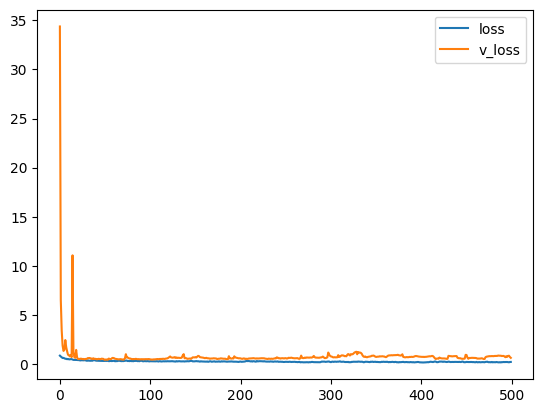

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9046 - loss: 0.2369 - val_accuracy: 0.7241 - val_loss: 0.6543


In [19]:
init_lr = 1e-3
epochs = 500
opt = Adam(learning_rate=init_lr)

myModel.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint_filepath = './best_model.weights.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

myModel.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[plot_losses, model_checkpoint_callback]
)

myModel.load_weights(checkpoint_filepath)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Area under the ROC curve : 0.542092
    fpr  tpr  1-fpr   tf  thresholds
22  0.5  0.5    0.5  0.0    0.167675


[Text(-10.0, 0, ''),
 Text(0.0, 0, ''),
 Text(10.0, 0, ''),
 Text(20.0, 0, ''),
 Text(30.0, 0, ''),
 Text(40.0, 0, ''),
 Text(50.0, 0, ''),
 Text(60.0, 0, '')]

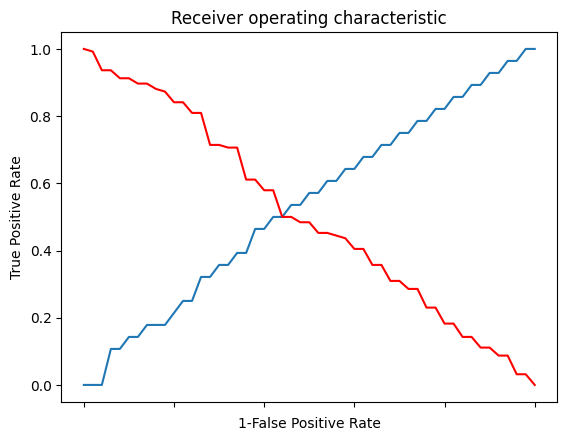

In [ ]:


ypred = myModel.predict(X_test)

from sklearn.metrics import roc_curve,auc
import pylab as pl
fpr, tpr, thresholds =roc_curve(y_test, ypred)
roc_auc = auc(fpr, tpr)

print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
print(roc.iloc[(roc.tf-0).abs().argsort()[:1]])

fig, ax = pl.subplots()
pl.plot(roc['tpr'])
pl.plot(roc['1-fpr'], color = 'red')
pl.xlabel('1-False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
ax.set_xticklabels([])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

optimal_threshold = roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
print("Umbral óptimo:", optimal_threshold)

y_pred_binary = (ypred >= optimal_threshold).astype(int)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_binary))

print("Reporte de clasificación:")
print(
    classification_report(
        y_test,
        y_pred_binary,
        target_names=["No prematuro", "Prematuro"]
    )
)

##El umbral óptimo fue determinado a partir de la curva ROC como el punto donde TPR − (1 − FPR) ≈ 0. 
#Con dicho umbral se calcularon precisión, sensibilidad (recall) y F1-score para cada clase.


Umbral óptimo: 0.16767515
Matriz de confusión:
[[63 63]
 [14 14]]
Reporte de clasificación:
              precision    recall  f1-score   support

No prematuro       0.82      0.50      0.62       126
   Prematuro       0.18      0.50      0.27        28

    accuracy                           0.50       154
   macro avg       0.50      0.50      0.44       154
weighted avg       0.70      0.50      0.56       154



In [ ]:
import pandas as pd
import numpy as np


results_df = pd.DataFrame({
    'true_label': y_test,
    'predicted_proba': ypred.flatten(),       
    'predicted_label': y_pred_binary.flatten()  
})

# Guardar en CSV
results_df.to_csv("predicciones_lstm_preterm.csv", index=False)

print("✅ Predicciones exportadas a 'predicciones_lstm_preterm.csv'")


✅ Predicciones exportadas a 'predicciones_lstm_preterm.csv'


In [ ]:
from sklearn.metrics import classification_report


report_dict = classification_report(
    y_test,
    y_pred_binary,
    target_names=["No prematuro", "Prematuro"],
    output_dict=True
)


report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("metricas_clasificacion_lstm.csv", index=True)

print("✅ Métricas exportadas a 'metricas_clasificacion_lstm.csv'")


✅ Métricas exportadas a 'metricas_clasificacion_lstm.csv'


✅ Curva ROC guardada como 'curva_roc_lstm.png'


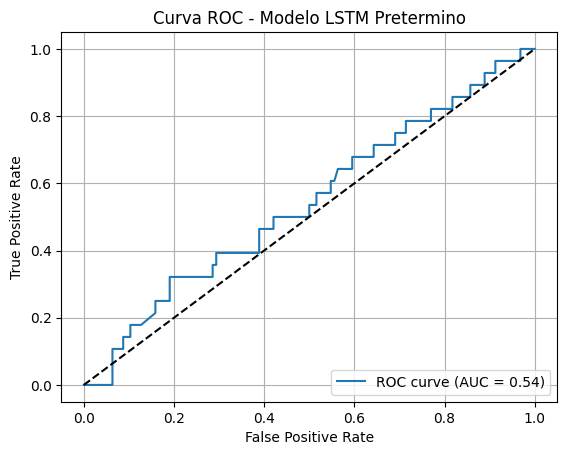

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo LSTM Pretermino')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("curva_roc_lstm.png", dpi=300)

print("✅ Curva ROC guardada como 'curva_roc_lstm.png'")


In [26]:

myModel.save("lstm_preterm3.h5")
